In [81]:
import pandas as pd
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pmdarima as pm

In [18]:
df = pd.read_csv("F-F_Research_Data_5_Factors_2x3.csv", index_col="Date").dropna()
df = df["196307":"202210"]
df["RMW"] = pd.to_numeric(df["RMW"], downcast="float")
df.index = pd.to_datetime(df.index, format="%Y%m", errors='coerce')
df

,Mkt-RF,SMB,HML,RMW,CMA,RF
Date,,,,,,
1963-07-01,-0.39,-0.41,-0.97,0.68,-1.18,0.27
1963-08-01,5.07,-0.80,1.80,0.36,-0.35,0.25
1963-09-01,-1.57,-0.52,0.13,-0.71,0.29,0.27
1963-10-01,2.53,-1.39,-0.10,2.80,-2.01,0.29
1963-11-01,-0.85,-0.88,1.75,-0.51,2.24,0.27
...,...,...,...,...,...,...
2022-06-01,-8.43,1.30,-5.97,1.85,-4.70,0.06
2022-07-01,9.57,1.87,-4.10,0.68,-6.94,0.08
2022-08-01,-3.77,1.51,0.31,-4.80,1.30,0.19


In [88]:
rmw = df["RMW"]
#annualized = df.RMW.resample('Y').mean()
print("Annualized mean: %f" % ((1+rmw.mean())**12-1))
print("Std: %f" % rmw.std())

Annualized mean: 17.258699
Std: 2.215742


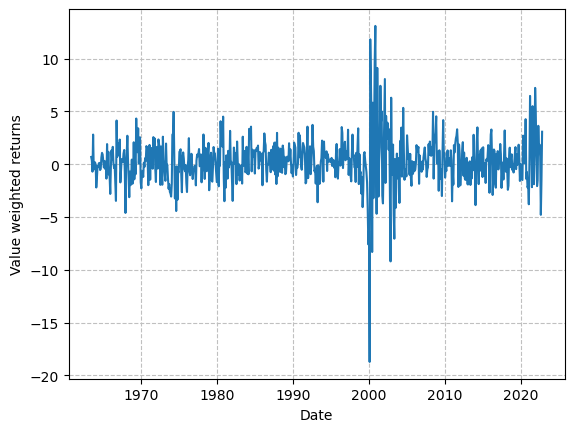

In [48]:
x = rmw.index
y = rmw
plt.xlabel("Date")
plt.ylabel("Value weighted returns")
plt.plot(x, y)
plt.grid(linestyle="--", color='silver')
plt.show()

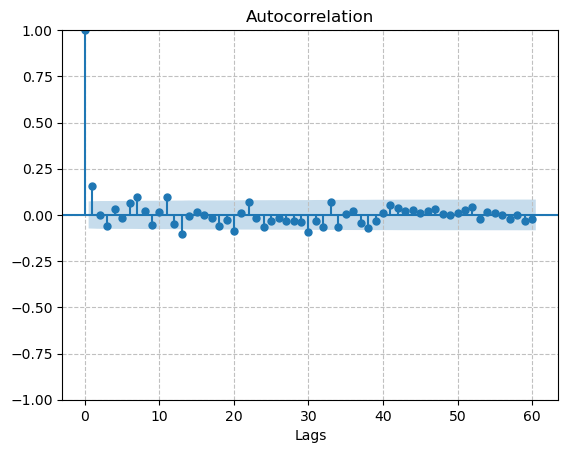

In [63]:
plot_acf(rmw, lags=60)
plt.xlabel("Lags")
plt.grid(linestyle="--", color='silver')
plt.show()

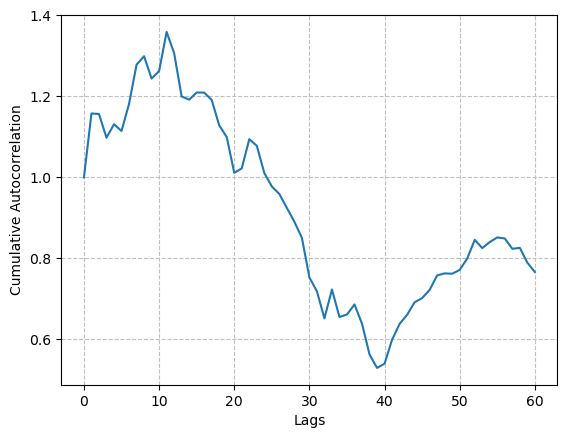

In [89]:
x = []
y = []
for i in range(0, 61):
    x.append(i)
    y_prev = 0
    if i > 0:
        y_prev = y[i-1]
    y.append(y_prev + pd.Series(rmw).autocorr(lag=i))
plt.xlabel("Lags")
plt.ylabel("Cumulative Autocorrelation")            
plt.plot(x, y)
plt.grid(linestyle="--", color='silver')
plt.show()

In [52]:
ljung_df = sm.stats.acorr_ljungbox(rmw, lags=[1,2,3,4,5,6], return_df=True)
ljung_df

,lb_stat,lb_pvalue
1,17.776381,0.000025
2,17.777537,0.000138
3,20.213448,0.000153
4,20.994316,0.000317
5,21.187655,0.000747
6,24.353801,0.000450


In [53]:
ljung_pval = ljung_df["lb_pvalue"].prod()
ljung_pval
#Fails to reject the null hypothesis that first 6 autocorrelations jointly are zero

5.596847919085371e-23

In [69]:
#1. For the model to exhibit least amount of errors x should have
# We need to model a time series with least autocorrelation so appropriate model could be an ARIMA model
# Lets try to find the most apt fitting ARIMA model
x_fit = pm.auto_arima(rmw, start_p=1, start_q=1, max_p=60, max_q=100,
                             start_P=0, seasonal=False, d=1, D=1, trace=True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True,  # don't want convergence warnings
                             stepwise=False, random=False)  # exhaustive search
x_fit.summary()

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3522.915, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.96 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.22 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.42 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=inf, Time=2.48 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3397.903, Time=0.25 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.20 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.79 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=3346.689, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.17 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.56 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.45 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=3283.909, Time=0.43 sec
 ARI

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  712
Model:               SARIMAX(5, 1, 0)   Log Likelihood               -1608.918
Date:                Sun, 22 Jan 2023   AIC                           3231.836
Time:                        17:35:56   BIC                           3263.803
Sample:                    07-01-1963   HQIC                          3244.185
                         - 10-01-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0016      0.092     -0.018      0.986      -0.182       0.179
ar.L1         -0.6770      0.015    -44.837      0.000      -0.707      -0.647
ar.L2         -0.5769      0.025    -23.501      0.000      -0.625      -0.529
ar.L3         -0.5019      0.024    -20.706      0.000      -0.549      -0.454
ar.L4         -0.3070      0.021    -14.848      0.000      -0.348      -0.266
ar.L5         -0.2276      0.026     -8.819      0.000      -0.278      -0.177
sigma2         5.4007      0.122     44.122      0.000       5.161       5.641
===================================================================================
Ljung-Box (L1) (Q):                   1.48   Jarque-Bera (JB):              4158.71
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               1.26   Skew:                             0.62
Prob(H) (two-sided):                  0.07   Kurtosis:                        14.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
x = x_fit.predict_in_sample()
x

1963-07-01   -0.000494
1963-08-01    0.679504
1963-09-01    0.488812
1963-10-01   -0.075626
1963-11-01    1.262576
                ...   
2022-06-01    1.493573
2022-07-01    0.740855
2022-08-01    0.621499
2022-09-01   -1.131370
2022-10-01    0.385327
Freq: MS, Name: predicted_mean, Length: 712, dtype: float64

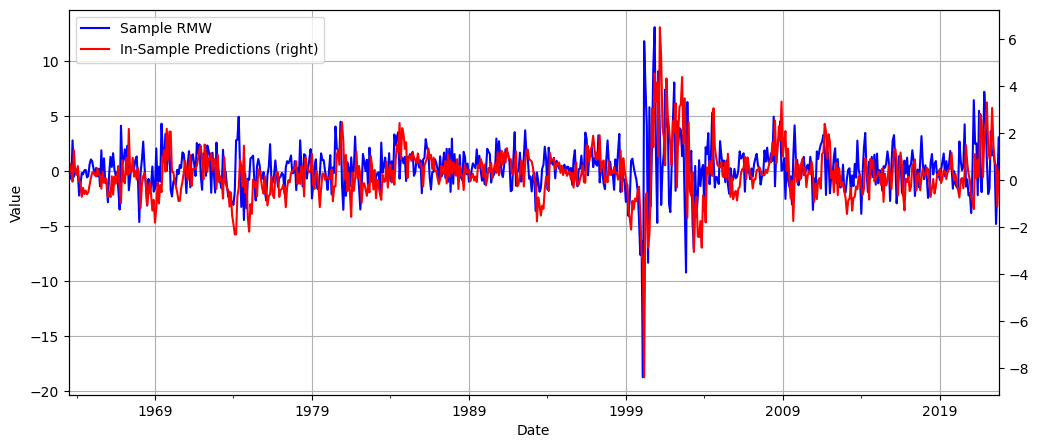

In [86]:
plt.figure(figsize=(12,5))
plt.xlabel('Time')
plt.ylabel('Value')

ax1 = rmw.plot(color='blue', grid=True, label='Sample RMW')
ax2 = x.plot(color='red', grid=True, secondary_y=True, label='In-Sample Predictions')

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=2)
plt.show()

In [ ]:
def calc_var